# Introduction to regularized regression

Despite ordinary least squares (OLS) being the best unbiased linear estimator for a system of equations, biased (regularized) estimators can achieve lower mean-squared error especially on unseen or held out data. This is particularly true when the number of predictors is high or compared to the number of observations (which can often be true for large neural encoding models)! OLS has no unique solution when there are more predictors than samples (this is referred to as an underdetermined system), therefore it will cross-validate quite poorly in this regime. 

Regularization will help overcome this problem because it reduces variance in order to improve model predictions on held out data. Regularization is also particularly useful when there is multicollinearity between your regressors. OLS suffers from large standard errors on the $\beta$ estimates in this regime.


When building encoding models for neural data, regressors often may be collinear. Let's take a basic neuroscience example of a mouse that must press a lever to recieve a food reward. If a food reward is delivered every time the lever is pressed, it will be quite difficult to separate out the neural encoding of action (lever pressing) from the encoding of reward (recieving food) because these variables always occur together (and occur closely in time). When designing behavioral tasks, think how you might avoid collinearities.


### Ridge, lasso and ordinary least squares (OLS)
The goal of regression is to minimize the sum of squared errors (SSE). Below are shown the different SSE formulations for OLS, ridge, and lasso regression.
$$
SSE_{OLS} = \sum_{i=1}^{n}{(y_i - \hat{y}_i)^2}
$$
$$
SSE_{Ridge} = \sum_{i=1}^{n}{(y_i - \hat{y}_i)^2} + \alpha\sum_{j=1}^{P}{\beta_j^2}
$$
$$
SSE_{Lasso} = \sum_{i=1}^{n}{(y_i - \hat{y}_i)^2} + \lambda\sum_{j=1}^{P}{|\beta_j|}
$$
You can see that the ridge and lasso equations include an additional term that penalizes large $\beta$ values. The only difference between ridge and lasso is that ridge is squared and lasso takes the absolute value of the weights instead. In practice, this translates to lasso regression having sparser solutions than ridge (less informative regressors will have $\beta$'s set to 0). By minimizing these functions, we can compute the OLS and Ridge estimators! We will skip over the derivation of the closed form solutions, but just know that they come from minimizing the above equations. 

$$
\hat{\beta}_{OLS} = (X^TX)^{-1}X^Ty
$$
$$
\hat{\beta}_{Ridge} = (X^TX + \alpha I)^{-1}X^Ty
$$
Lasso regression has no closed form solution. It must be solved with other techniques such as gradient descent, so we will omit it for now.


In [17]:
#First import the standard toolboxes
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sklearn

#Import the specific functions for this class
import encoding_tools

We will import a dataset that gives the average miles per gallon (MPG) for many different cars. The displacement, horsepower, cylinders, and other information about the cars is also included. We will try to see how well we can predict fuel efficiency from these variables.

In [18]:
PREDICTOR_LABELS = ['cylinders','displacement','horsepower','weight','acceleration','model_year','american','japanese']
dataset = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv')
dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


The shape of x is (392, 8)
The shape of y is (392,)


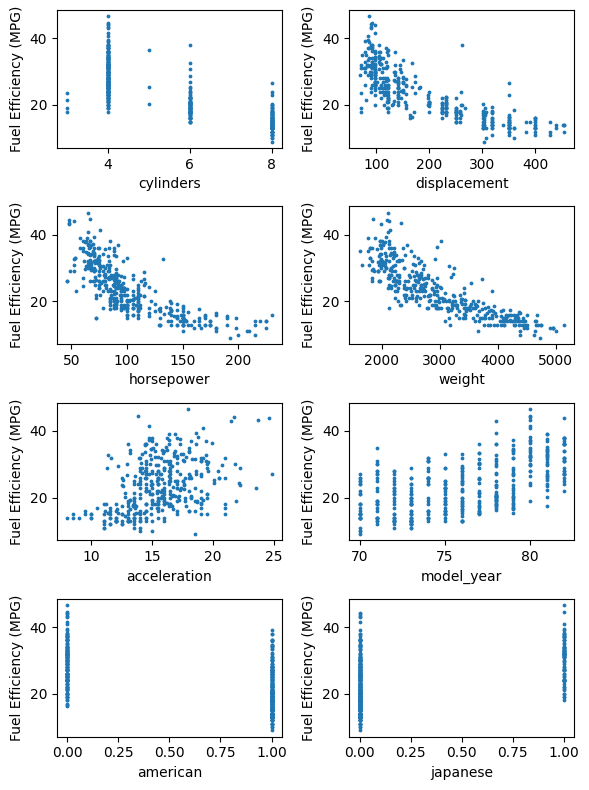

In [19]:
# Preprocess the data
dataset = dataset.dropna()
y = dataset.mpg.values
x = dataset[PREDICTOR_LABELS[:-2]].to_numpy()

is_american = (dataset.origin == 'usa').values #dummy variable
is_japanese = (dataset.origin == 'japan').values #dummy variable

x = np.vstack((x.T, is_american, is_japanese)).T
print(f'The shape of x is {x.shape}')
print(f'The shape of y is {y.shape}')

# Plot each of the regressors vs MPG so we have some idea how they relate
fig,axs = plt.subplots(4,2,figsize=(6,8),dpi=100)
for i,ax in enumerate(np.ravel(axs)):
    ax.scatter(x[:,i],y, s=3)
    ax.set_xlabel(PREDICTOR_LABELS[i])
    ax.set_ylabel('Fuel Efficiency (MPG)')
fig.tight_layout()

x = x / np.max(x, axis=0) # normalize columns of x. Why must we do this for ridge regression?
y = y / np.max(y, axis=0)
y = y - np.mean(y, axis=0) # mean center y. Why must we do this for ridge regression?



### Excercise 1: Implement OLS and Ridge regression
Use the equations at the beginning of the notebook to compute the $\beta$ estimates using OLS and ridge regression. 

In [20]:
def ols_solver(x,y):
    betas = np.linalg.inv(x.T @ x) @ x.T @ y # the @ symbol is equivalent to np.matmul()
    return betas

def ridge_solver(x,y,alpha):
    betas = np.linalg.inv(x.T @ x + alpha*np.identity(x.shape[1])) @ x.T @ y
    return betas

RIDGE_ALPHA = 00 #TODO: What alpha value will make ridge regression equal to ordinary least squares?

ols_betas = ols_solver(x,y)
ridge_betas = ridge_solver(x,y,RIDGE_ALPHA)

for label, ols_beta, ridge_beta in zip(PREDICTOR_LABELS, ols_betas, ridge_betas):
    print(f'OLS beta weight for {label}: {ols_beta}')
    #print(f'ridge beta weight for {label}: {ridge_beta}')

assert np.array_equiv(ols_betas,ridge_betas), "Betas not equal, change RIDGE_ALPHA so that they will become equal"
print('\nHow do the beta weights match up with what you expected from the plots above?')


OLS beta weight for cylinders: -0.1721954222078835
OLS beta weight for displacement: 0.28944919176240197
OLS beta weight for horsepower: -0.3565519046454315
OLS beta weight for weight: -0.6152002986330847
OLS beta weight for acceleration: -0.15115864761530096
OLS beta weight for model_year: 0.6868295904533908
OLS beta weight for american: -0.04914940764127097
OLS beta weight for japanese: 0.012784081681241306

How do the beta weights match up with what you expected from the plots above?


### Excercise 2: Generate model predictions and implement a scoring function
There are many ways to assess a models performance (many of them are also built into scikit-learn, which we will use later). But for now, lets practice building our own custom scoring function. We will use the *coefficient of determination* ($R^2$), which is a useful scoring metric to evaluate linear encoding models. 
$$
R^2 = 1 - \frac{\sum_i(y_i - \hat{y}_i)^2}{\sum_i(y_i - \bar{y})^2}
$$
This is the proportion of the dependent variable that is predictable from the independent variables. Usually, its value ranges from 0 to 1, though values can go negative when scoring on held out (cross-validated) data. What might a negative $R^2$ mean?


In [21]:
def r_squared_score(y_true, y_pred):
    numerator = ((y_true - y_pred) ** 2).sum(axis=0)
    denominator = ((y_true - np.average(y_true, axis=0)) ** 2).sum(axis=0)
    r_squared = 1 - numerator / denominator
    return r_squared

y_pred_ols = x @ ols_betas
y_pred_ridge = x @ ridge_betas

r2_ols = r_squared_score(y,y_pred_ols)
r2_ridge = r_squared_score(y,y_pred_ridge) # if the ridge parameter (alpha) was set to zero, these scores should be equivalent

print(f'OLS R-squared: {r2_ols}')
print(f'Ridge R-squared: {r2_ridge}')

OLS R-squared: 0.7916261237759589
Ridge R-squared: 0.7916261237759589


Now let's vary the ridge parameter and see how our model performs. Do you think ridge or OLS will perform better? Where will they be equivalent? Remember, we are not doing cross-validation yet. 

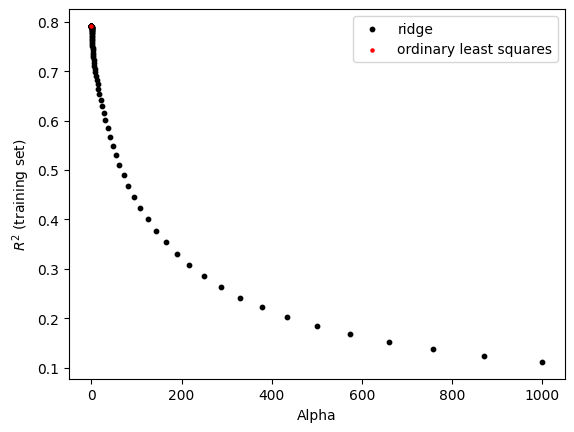

In [22]:
ALPHAS = 10**np.linspace(-9,3,200)

scores = np.empty_like(ALPHAS)
for i,alpha in enumerate(ALPHAS):
    betas = ridge_solver(x,y,alpha)
    scores[i] = r_squared_score(y, x @ betas)

plt.scatter(ALPHAS,scores, s=10, color='black', label='ridge')
plt.scatter(0, r_squared_score(y, x @ ols_solver(x,y)), s=5, color='red',label='ordinary least squares') # plot OLS score
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('$R^2$ (training set)')
plt.show()

### Excercise 3: Implement cross-validation

As you saw in the previous exercise, ridge regression will actually never perform better than ordinary least squares when assessing performance on training data. The power of regularization comes when generating predictions on held out data (cross-validation). When assessing model performance, it is best practice to do this on cross validated data. This ensures our model is not over-fitting and that it will be able to make reliable predictions on new data. In this toy example about fuel efficiency, we want a model that will give us a good prediction for a *new* car where the fuel efficiency is not availible. 

Here, we are going to implement k-fold cross validation. K-fold cross validation splits our data sets into k chunks. We will leave one chunk of the data out for testing (with our function `r_squared_score()`). We will train our model on the remaining data, and then go back and make predictions on the held out data.

Here's a nice visualization of 5-fold crossvalidation
![k-fold crossval figure](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*AAwIlHM8TpAVe4l2FihNUQ.png)
https://towardsdatascience.com/cross-validation-k-fold-vs-monte-carlo-e54df2fc179b

SKLearn has several useful functions for cross-validation. We will make use of one of them here.

OLS test performance: 0.7764870277956074
Best ridge test performance: 0.7885068114766286


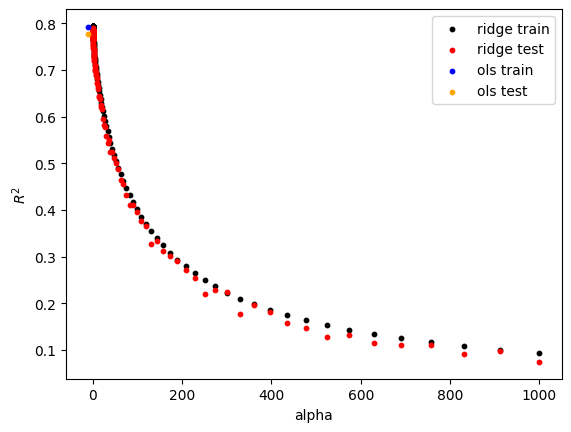

In [23]:
from sklearn.model_selection import KFold
N_FOLDS = 5
ALPHAS = 10**np.linspace(-9,3,300)

def k_fold_crossval(x, y, n_folds, scoring_function, fitting_function, **fitting_func_kwargs):
    kf = KFold(n_splits=N_FOLDS, shuffle=True)
    train_scores = np.empty((N_FOLDS))
    test_scores = np.empty((N_FOLDS))
    for j, (train_index, test_index) in enumerate(kf.split(x)):
        x_train, x_test = x[train_index,:], x[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        betas = fitting_function(x=x_train,y=y_train,**fitting_func_kwargs)
        y_train_predictions = x_train @ betas
        y_test_predictions = x_test @ betas
        train_scores[j] = scoring_function(y_train, y_train_predictions)
        test_scores[j] = scoring_function(y_test, y_test_predictions)
    return np.mean(train_scores), np.mean(test_scores)

train_scores, test_scores = [],[]
for alpha in ALPHAS:
    train_r2, test_r2 = k_fold_crossval(x, y, N_FOLDS, r_squared_score, ridge_solver, alpha=alpha)
    test_scores.append(test_r2)
    train_scores.append(train_r2)

ols_train_r2, ols_test_r2 = k_fold_crossval(x, y, N_FOLDS, r_squared_score, ols_solver)

plt.scatter(ALPHAS, train_scores, s=10, color='black',label='ridge train')
plt.scatter(ALPHAS, test_scores, s=10, color='red',label='ridge test')
plt.scatter(-10, ols_train_r2, s=10, color='blue',label='ols train')
plt.scatter(-10, ols_test_r2, s=10, color='orange',label='ols test')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('$R^2$')

print(f'OLS test performance: {ols_test_r2}')
print(f'Best ridge test performance: {np.max(test_scores)}')

Look at the above plot and consider the following:
- Are the OLS or ridge models overfitting?
- is ridge regression needed in this case?

### Excercise 4: Regression with collinear regressors and underdetermined systems

In the plot above, you may have noticed that ridge regression test performance is only *slightly* better than ordinary least squares. This is because we have a well conditioned dataset. As we introduced at the beginning of the notebook, where regularization becomes most helpful is when you have few observations relative to the number of regressors or when regressors are collinear. Let's manipulate our regressor matrix $X$ and compare OLS and ridge again.

Shape of x is originally (392, 8)
Shape of x with data augmentation is (392, 32)
Shape of x after subsampling is (50, 32)
OLS test R^2: -0.6868237575226752
Best ridge test R^2: 0.7637081191731722
Best ridge parameter (alpha): 1.0060201005025124


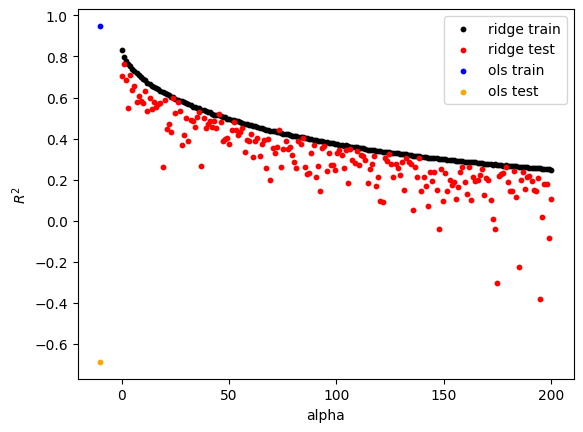

In [24]:
# augment matrix x with noisy versions of itself
random_offset = x + np.random.normal(scale=1e-5, size=x.shape) # same as x but with small random differences
random_offset_2 = x + np.random.normal(scale=1e-3, size=x.shape)
random_offset_3 = x + np.random.normal(scale=1e-7, size=x.shape)
x_augmented = np.hstack((x, random_offset, random_offset_2, random_offset_3)) # add columns to x that are nearly identical. This is an "ill-conditioned" matrix but still full rank. 

#x_augmented = np.hstack((x, x)) # This matrix exhibits multicollinearity (it is not full rank). Uncomment and see how OLS vs ridge handle this.
x_augmented = x_augmented / np.max(x_augmented, axis=0)

print(f'Shape of x is originally {x.shape}')
print(f'Shape of x with data augmentation is {x_augmented.shape}')

# now let's subsample x so that the number of observations is closer to the number of regressors
N_SUBSAMPLE = 50 #The number of observations to randomly grab 

subsample_indices = np.random.choice(x_augmented.shape[0], N_SUBSAMPLE, replace=False)
x_subsample = x_augmented[subsample_indices,:]
y_subsample = y[subsample_indices]
print(f'Shape of x after subsampling is {x_subsample.shape}')

ALPHAS = np.linspace(.001,200, 200)
train_scores, test_scores = [],[]
for alpha in ALPHAS:
    train_r2, test_r2 = k_fold_crossval(x_subsample, y_subsample, N_FOLDS, r_squared_score, ridge_solver, alpha=alpha)
    test_scores.append(test_r2)
    train_scores.append(train_r2)

ols_train_r2, ols_test_r2 = k_fold_crossval(x_subsample, y_subsample, N_FOLDS, r_squared_score, ols_solver)

plt.scatter(ALPHAS, train_scores, s=10, color='black',label='ridge train')
plt.scatter(ALPHAS, test_scores, s=10, color='red',label='ridge test')
plt.scatter(-10, ols_train_r2, s=10, color='blue',label='ols train')
plt.scatter(-10, ols_test_r2, s=10, color='orange',label='ols test')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('$R^2$')

print(f'OLS test R^2: {ols_test_r2}')
print(f'Best ridge test R^2: {np.max(test_scores)}')
print(f'Best ridge parameter (alpha): {ALPHAS[np.argmax(test_scores)]}')


Look at this plot after adding in more predictor variables and reducing the number of observations and consider the following:
- How are the two models performing? Are they overfitting?
- Previously, the OLS and ridge fits had similar $R^2$ values, now they look wildly different for the test data. Why do you think this is?
- See what happens when you modify `N_SUBSAMPLE`. How does this affect the results?
- Will these methods work on a collinear matrix? Try it and see what happens
- What will the $\beta$ weights look like for OLS and ridge? Will there be a unique solution for OLS and ridge?

### Up next: Selecting the proper value of alpha and fitting to neural data!
Since $\alpha$ is a model hyperparameter, it is important that the proper value is selected to get the best model performance. Cross-validating with many different alphas (what we did above) is one way to do that, but there are other ways it can be done. See Karabastos 2017, *Communications in Statistics* for another method of $\alpha$ selection. The Karabastos method is the one implemented in the Musall 2019 paper we discussed.

In the next notebook, we will fit an encoding model to neural data and solve it with ridge regression!